In [1]:
from api import WeatherApi
from gpx import read_gpx, read_gpx_dir

import matplotlib.pyplot as plt
import sklearn as sk
import pickle as pkl

In [2]:
api = WeatherApi()
df = read_gpx_dir(api, "data")

Feature importances: [0.28451626 0.40727595 0.10717795 0.20102984]


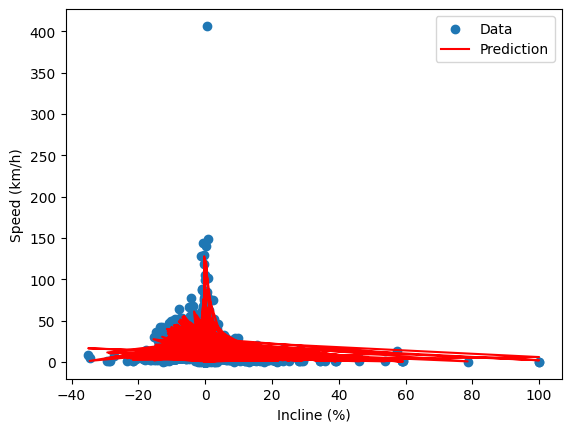

Mean Squared Error: 10.39
R^2 Score: 0.89


In [15]:
regressor = sk.ensemble.RandomForestRegressor(n_estimators=100)
X = df[["incline", "elapsed", "temperature", "cos_course"]]
y = df["speed"]

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    X.values, y, test_size=0.2
)

regressor.fit(X_train, y_train)
regressor.score(X_test, y_test)

print("Feature importances:", regressor.feature_importances_)
plt.scatter(X_test[:, 0], y_test, label="Data")
plt.plot(X_test[:, 0], regressor.predict(X_test), color="red", label="Prediction")
plt.xlabel("Incline (%)")
plt.ylabel("Speed (km/h)")
plt.legend()
plt.show()

# error
from sklearn.metrics import mean_squared_error, r2_score

y_pred = regressor.predict(X.values)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

In [18]:
with open("model.pkl", "wb") as f:
    pkl.dump(regressor, f)